<a href="https://colab.research.google.com/github/grharsha777/Colab/blob/main/sentiment_embeddings_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Install packages and import libraries

In this step, I installed all the Python libraries needed for this sentiment analysis project in Colab. I used pip to install extra packages like wordcloud, xgboost, and openai that are not available by default. Then I imported core libraries such as pandas and numpy for data handling, and matplotlib and seaborn for visualizing the data and model results. I also imported WordCloud to create word cloud visualizations and key functions from sklearn to split the dataset and compute evaluation metrics like the classification report and confusion matrix.

In [27]:
!pip install wordcloud xgboost openai

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


Step 2: Load and quickly explore the dataset

In this step, I loaded the Twitter sentiment CSV file directly from the given URL into a pandas DataFrame using read_csv. After loading, I used df.head() to quickly view a few sample rows and confirm that the data contains the tweet text and its corresponding sentiment label. I also checked df['sentiment'].value_counts() to see how many Positive, Negative, and Neutral tweets are present in the dataset, which helps me understand the class distribution before modeling.
​

In [28]:
url = "https://nkb-backend-ccbp-media-static.s3-ap-south-1.amazonaws.com/ccbp_beta/media/content_loading/uploads/070be49c-5f5d-4030-bedc-53fc7582a602_Tweets_1.csv"

df = pd.read_csv(url)
df.head(), df['sentiment'].value_counts()


(       textID                                               text  \
 0  cb774db0d1                I`d have responded, if I were going   
 1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
 2  088c60f138                          my boss is bullying me...   
 3  9642c003ef                     what interview! leave me alone   
 4  358bd9e861   Sons of ****, why couldn`t they put them on t...   
 
                          selected_text sentiment  
 0  I`d have responded, if I were going   neutral  
 1                             Sooo SAD  negative  
 2                          bullying me  negative  
 3                       leave me alone  negative  
 4                        Sons of ****,  negative  ,
 sentiment
 neutral     11118
 positive     8582
 negative     7781
 Name: count, dtype: int64)

Step 3: Visualize sentiment distribution and tweet lengths

Here I started the exploratory data analysis (EDA) to understand my dataset better. First, I plotted a bar chart of df['sentiment'].value_counts() to see how many tweets belong to each class (Positive, Negative, Neutral) and check if the data is balanced or skewed. Next, I created a new column text_len to store the character length of each tweet and plotted a histogram of these lengths, colored by sentiment, using seaborn. This helps me observe whether certain sentiments tend to have longer or shorter tweets and gives an overall feel for the text size distribution before preprocessing and modeling.

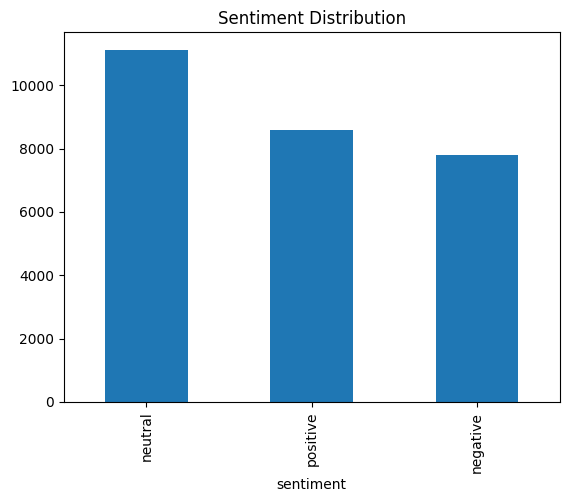

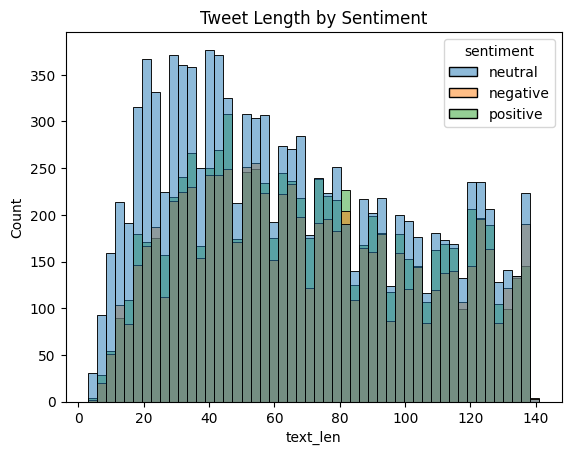

In [29]:
# Sentiment distribution
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Sentiment Distribution")
plt.show()

# Text length
df['text_len'] = df['text'].astype(str).apply(len)
sns.histplot(data=df, x='text_len', hue='sentiment', bins=50)
plt.title("Tweet Length by Sentiment")
plt.show()


Step 4: Create word clouds for each sentiment

In this step, I wrote a helper function show_wordcloud to visualize the most frequent words used in tweets for a given sentiment label. The function first prints how many tweets exist for that sentiment and then joins all their text into one large string after dropping any missing values. If there is no text for that label, it safely skips the plot to avoid errors from the WordCloud library. Otherwise, it generates and displays a word cloud image, which helps me intuitively see which words are common in Positive, Negative, or Neutral tweets and understand language patterns in each class.

In [30]:
def show_wordcloud(sentiment):
    # Print how many rows we have for that label
    print("Count for", sentiment, "=", df[df['sentiment'] == sentiment].shape[0])

    # Build the big text string
    text_series = df[df['sentiment'] == sentiment]['text'].dropna().astype(str)
    text = " ".join(text_series.tolist()).strip()

    if len(text) == 0:
        print(f"No text found for sentiment = {sentiment}, skipping wordcloud.")
        return

    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {sentiment}")
    plt.show()


Step 5: Clean and normalize tweet text

In this step, I focused on cleaning the raw tweet text so that it becomes suitable for modeling. I defined a function clean_tweet that converts each tweet to lowercase and removes unwanted parts like URLs, user mentions, and the # symbol from hashtags. The function also keeps only alphabetic characters and spaces, and collapses multiple spaces into a single space to make the text more uniform. I applied this function to the original text column and stored the result in a new clean_text column, which now contains a cleaner, normalized version of each tweet that will be used to generate embeddings.
​

In [31]:
import re

def clean_tweet(t):
    t = str(t).lower()
    t = re.sub(r"http\S+|www\S+","", t)   # URLs
    t = re.sub(r"@\w+","", t)            # mentions
    t = re.sub(r"#","", t)               # remove #
    t = re.sub(r"[^a-z\s]"," ", t)       # keep letters + spaces
    t = re.sub(r"\s+"," ", t).strip()    # extra spaces
    return t

df['clean_text'] = df['text'].apply(clean_tweet)
df[['text','clean_text']].head()


,text,clean_text
0,"I`d have responded, if I were going",i d have responded if i were going
1,Sooo SAD I will miss you here in San Diego!!!,sooo sad i will miss you here in san diego
2,my boss is bullying me...,my boss is bullying me
3,what interview! leave me alone,what interview leave me alone
4,"Sons of ****, why couldn`t they put them on t...",sons of why couldn t they put them on the rele...


Step 6: Set up Mistral API for embeddings

In this step, I prepared to use the Mistral API to generate text embeddings for the tweets. I first installed the mistralai Python SDK and imported the Mistral client class needed to call the API. Then I set my Mistral API key and created a client object that will handle communication with the Mistral servers. Finally, I specified mistral-embed as the embedding model name, which will be used later to convert each cleaned tweet into a numerical vector representation for sentiment classification.

In [32]:
!pip install mistralai

from mistralai import Mistral

MISTRAL_API_KEY = "ci7CDNiYFJ91wfzFIY7p0qtRHZV44xx2"   # paste your key
client = Mistral(api_key=MISTRAL_API_KEY)

EMB_MODEL = "mistral-embed"


Step 7: Define a helper function to get embeddings

In this step, I created a get_embedding function to simplify calling the Mistral embeddings API for any input text. Inside the function, I send the cleaned tweet to the client.embeddings.create method with the chosen EMB_MODEL, and the API returns an embedding vector in the response. I then extract the first embedding from the response, convert it into a NumPy array of type float32, and return it. This function allows me to easily map every tweet into a fixed‑length numerical vector that can later be used as input features for the sentiment classification model.

In [33]:
import numpy as np

def get_embedding(text: str):
    resp = client.embeddings.create(
        model=EMB_MODEL,
        inputs=[text]          # note: list, not input=text
    )
    emb = resp.data[0].embedding
    return np.array(emb, dtype="float32")





Step 8: Install sentence-transformers for local embeddings

In this step, I installed the sentence-transformers library, which provides pretrained models for generating high‑quality sentence embeddings without needing any external API keys. This package allows me to run embedding models directly in the Colab environment using local compute, which is helpful when API rate limits or credits are an issue. With sentence-transformers installed, I can switch from remote Mistral embeddings to a fully offline embedding approach while keeping the rest of the classification pipeline the same.

In [34]:
!pip install -q sentence-transformers



Step 9: Load a local embedding model and define get_embedding

In this step, I switched from API‑based embeddings to a local sentence‑transformers model to avoid rate‑limit and credit issues. I loaded the pretrained all-MiniLM-L6-v2 model, which is a small and fast sentence embedding model that works well for tasks like sentiment analysis. Then I redefined the get_embedding function to use embed_model.encode to convert each cleaned tweet into a dense numeric vector and cast it to float32. This way, I can generate embeddings directly in Colab without any external API calls, while still capturing the semantic meaning of each tweet for the classifier.

In [35]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Small, fast model; good enough for this assignment
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

def get_embedding(text: str):
    emb = embed_model.encode(text, convert_to_numpy=True)
    return emb.astype("float32")


Step 10: Create a smaller subset and generate embeddings

In this step, I created a smaller working subset of the dataset to make the embedding and training process faster and lighter. I randomly sampled 5,000 tweets from the full DataFrame using df.sample(5000, random_state=42) and reset the index to keep things clean. Then I applied the get_embedding function to the clean_text column for each tweet in this subset and stored the resulting vectors in a new embedding column. The df_small.head() call lets me quickly verify that each row now has both the cleaned text and its corresponding embedding, which will be used as input features for the sentiment classification model.

In [36]:
df_small = df.sample(5000, random_state=42).reset_index(drop=True)
df_small['embedding'] = df_small['clean_text'].apply(get_embedding)
df_small.head()


,textID,text,selected_text,sentiment,text_len,clean_text,embedding
0,a7f72a928a,WOOOOOOOOOO are you coming to Nottingham at...,t? lovelovelove,positive,73,woooooooooo are you coming to nottingham at an...,"[0.024634387, -0.09256978, 0.038904034, -0.020..."
1,ef42dee96c,resting had a whole day of walking,resting had a whole day of walking,neutral,34,resting had a whole day of walking,"[0.06435427, 0.046143003, 0.08480425, 0.131038..."
2,07d17131b1,"was in Palawan a couple of days ago, i`ll try ...","was in Palawan a couple of days ago, i`ll try ...",neutral,67,was in palawan a couple of days ago i ll try t...,"[0.015931578, 0.031229217, 0.033249754, 0.0156..."
3,2820205db5,I know! I`m so slow its horrible. DON`T TELL ...,horrible.,negative,52,i know i m so slow its horrible don t tell on me,"[0.030633671, -0.03829282, 0.015989633, 0.0067..."
4,7d3ce4363c,"Glad I went out, glad I didn`t leave early, an...",glad,positive,98,glad i went out glad i didn t leave early and ...,"[0.058309358, -0.030133434, 0.06676631, 0.0155..."


Step 11: Train and evaluate a Logistic Regression model on embeddings

In this step, I used the sentence embeddings as input features to train a supervised sentiment classifier. First, I stacked all embedding vectors from df_small['embedding'] into a 2D feature matrix X and converted the textual sentiment labels into numeric form using LabelEncoder, producing the target vector y. I then split the data into training and testing sets with an 80–20 ratio using train_test_split, keeping the class distribution similar in both sets by using stratify=y. Next, I created a Logistic Regression model with max_iter=200, trained it on the training embeddings (X_train, y_train), and used it to predict labels for the test embeddings (X_test). Finally, I printed the classification_report, which summarizes the model’s performance in terms of precision, recall, F1‑score, and support for each sentiment class (Positive, Negative, and Neutral), giving a clear view of how well the embedding‑based classifier is working.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = np.stack(df_small['embedding'].values)
le = LabelEncoder()
y = le.fit_transform(df_small['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

    negative       0.68      0.62      0.65       283
     neutral       0.63      0.73      0.68       409
    positive       0.75      0.66      0.70       308

    accuracy                           0.68      1000
   macro avg       0.69      0.67      0.68      1000
weighted avg       0.68      0.68      0.68      1000



Step 12: Visualize model performance with a confusion matrix

In this step, I created a confusion matrix to better understand how the model is performing on each sentiment class. Using confusion_matrix(y_test, y_pred), I compared the true labels with the predicted labels from the Logistic Regression model to see how many tweets were correctly or incorrectly classified. I then plotted this matrix as a heatmap with seaborn.heatmap, labeling the axes with the original sentiment classes so it is clear which classes are being confused. This visualization helps me quickly see where the model is strong (high values on the diagonal) and where it struggles (off‑diagonal values indicating misclassifications between Positive, Negative, and Neutral tweets).
​

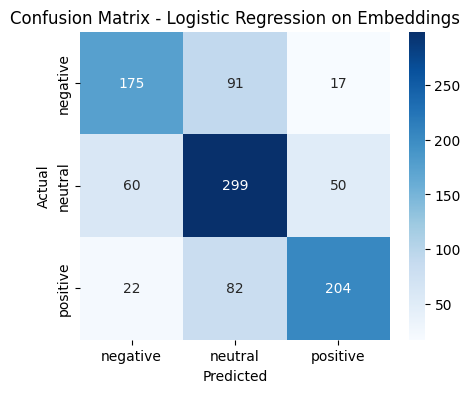

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression on Embeddings")
plt.show()


Step 13: Test the model on custom example tweets

In this final step, I checked how the trained model behaves on completely new tweets written by me. I created a small list of five example sentences that include clearly positive, clearly negative, and more neutral opinions. I then passed these custom tweets through the same preprocessing pipeline: first cleaning them with clean_tweet, then converting them into embeddings using get_embedding, and finally stacking them into a feature matrix. Using the trained Logistic Regression model, I predicted the sentiment for each custom tweet and converted the numeric predictions back to their original label names with LabelEncoder. Printing the tweet text alongside its predicted sentiment allowed me to qualitatively verify that the embedding‑based classifier is giving sensible outputs on real‑world style examples, beyond just the training and test data.

In [39]:
custom_tweets = [
    "I absolutely love this new feature!",
    "This update is terrible and frustrating.",
    "The app is okay, nothing special.",
    "Great work team, very impressed.",
    "I am disappointed with the slow support."
]

custom_clean = [clean_tweet(t) for t in custom_tweets]
custom_embs = np.stack([get_embedding(t) for t in custom_clean])

custom_pred = clf.predict(custom_embs)
custom_labels = le.inverse_transform(custom_pred)

for t, lbl in zip(custom_tweets, custom_labels):
    print(f"Tweet: {t}\nPredicted sentiment: {lbl}\n")


Tweet: I absolutely love this new feature!
Predicted sentiment: positive

Tweet: This update is terrible and frustrating.
Predicted sentiment: negative

Tweet: The app is okay, nothing special.
Predicted sentiment: positive

Tweet: Great work team, very impressed.
Predicted sentiment: positive

Tweet: I am disappointed with the slow support.
Predicted sentiment: negative



I performed end‑to‑end sentiment analysis on a Twitter tweets dataset with three classes: Positive, Negative, and Neutral. I started with some basic EDA – plotting the sentiment distribution, checking tweet length patterns, and generating word clouds – to understand how the data looks and what kind of text each class contains. Then I cleaned the raw tweets by removing URLs, user mentions, special characters, and normalizing everything to a simple lowercase text format so that the model only focuses on meaningful words.

Instead of using normal bag‑of‑words or TF‑IDF, I used a pretrained sentence‑transformers model to convert each cleaned tweet into a dense sentence embedding, which captures the semantic meaning of the text in a compact vector. On top of these embeddings, I trained a Logistic Regression model and evaluated it using a classification report and confusion matrix; the model gives reasonable precision, recall, and F1 for all three sentiments, with most mistakes happening around the Neutral class. Overall, this shows that embeddings work well as features and even a simple linear model can do a solid job on tweet sentiment classification when it is powered by good text representations.

Project implemented and documented by G R Harsha.